In [9]:
from rdkit import Chem
import numpy as np
import scipy.spatial
import numpy.linalg as LA
import matplotlib
from stl import mesh
import sys
import scipy
import gif
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits
from matplotlib import pyplot
#import mplot3d
from matplotlib import pyplot
import mpl_toolkits.mplot3d as mplot3d
import pandas as pd
#!conda install --yes --prefix {sys.prefix} stl
#!{sys.executable} -m pip uninstall -y stl
#!{sys.executable} -m pip uninstall -y numpy-stl
#!{sys.executable} -m pip install -U gif

#chem stuff 
import py3Dmol as py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #


In [2]:
no_of_rows=16
no_of_cols=5
your_mesh = mesh.Mesh.from_file("C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosohedron.stl")


In [3]:
## FUNCTIONS 
def atoms_from_mol_file(mol_file,no_of_atoms,verbose=True):
    """Grabs the atoms from a read in version of a molfile"""
    chopped_mol=mol_file.split('\n')[4:]
    atom_list=[]
    for idx in range(no_of_atoms):
        if verbose:
            print(chopped_mol[idx])
        line=chopped_mol[idx].split(' ')
        data=[x for x in line if not x =='']
        if verbose:
            print(data[3])
        atom_list.append(data[3])
    return atom_list

def coords_from_smiles_strings(smiles_string, verbose=False):
    """Uses RDKit to add Hydrogens, get 3D coords, do a simple minimisation
    and outputs coords and atom types. 
    Repeated use yields slightly different coords"""
    # example - molecules is randomly rotated each time this is called
    # grab a smiles string
    m2 = Chem.MolFromSmiles(smiles_string) 
    # embed it what ever that is
    AllChem.EmbedMolecule(m2)
    # add some hydrogens
    m3 = Chem.AddHs(m2)
    # embed it again? I think this makes a molecule object but who knows
    AllChem.EmbedMolecule(m3) 
    # use MMFF94 to minimise and make a nice structure
    AllChem.MMFFOptimizeMolecule(m3)
    # get molefile
    mol_file=Chem.MolToMolBlock(m3)
    if verbose:
        print(mol_file)  
    #AllChem.Compute2DCoords(m2)
    #coords=[]
    for c in m3.GetConformers():
        if verbose:
            print(c.GetPositions())
    coords=c.GetPositions()
    no_of_atoms=c.GetNumAtoms()
    atom_list=atoms_from_mol_file(mol_file, no_of_atoms,verbose=verbose)
    # print m3 imag3e
    m3
    return m3, coords, atom_list

df_colors = pd.read_csv("C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\JMolColors-master\\JMolColors-master\\jmolcolors.csv")

def get_colour(atom):
    """
    Returns RGB color tuple corresponding to atom

    :param str atom: symbol for atom
    """
    r = df_colors[df_colors['atom'] == atom]['R'].values[0] / 255.0
    g = df_colors[df_colors['atom'] == atom]['G'].values[0] / 255.0
    b = df_colors[df_colors['atom'] == atom]['B'].values[0] / 255.0
    return (r, g, b)

def get_colour_list(atom_list):
    colour_list=[]
    for atom in atom_list:
        if atom == 'H':
            colour=(0,0.5,0.5)
        else:
            if atom == 'C':
                colour=(0,0,0)
            else:
                colour=get_colour(atom)
        colour_list.append(colour)
    return colour_list

def select_mesh(ico):

    if ico==1:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosohedron.stl"
        no_of_rows=4
        no_of_cols=5
    elif ico==2:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosphere2.stl"
        no_of_rows=16
        no_of_cols=5
    else:
        mesh_file=mesh_file
    your_mesh=mesh.Mesh.from_file(mesh_file)
    return your_mesh, no_of_rows, no_of_cols

def calculate_triangle_for_coords(coords, scale_by, your_mesh):
    """Returns the triangle for each atom, normal and cosine distance"""
    triangles=[]
    for atom in coords:
        dot_products=[]
        length_of_cross_products=[]
        cosine_list=[]
        for normal in your_mesh.normals:
            #print(normal)
            normal=normal*scale_by
            #print(np.dot(normal,atom))
            #print(scipy.spatial.distance.cosine(normal,atom))
            dot_products.append(np.dot(normal,atom))
            length_of_cross_products.append(LA.norm(np.cross(normal,atom)))
            cosine_list.append(scipy.spatial.distance.cosine(normal,atom))
            #print(LA.norm(np.cross(normal,atom)))
        triangles.append(np.where(cosine_list==min(cosine_list))[0][0])
    return triangles

def first_row_of_net(chosen_triangle_index, 
                     chosen_direction, 
                     no_of_rows, 
                     no_of_cols, 
                     your_mesh,
                     verbose=True):
    """This creates the first row of the net and everything else follows from this
    chosen_triangle_index is which triangle to start from
    chosen_direction is which of the 3 vertices to use as the top most point of ([0,1,2])
    the icosphere
    no_of_rows
    no_of_coloums"""
    if verbose:
        print('###### Generating top row now ######')
    net = np.empty((no_of_rows,no_of_cols),dtype='int')
    net[:]=np.nan
    all_triangle_indices=[x for x in range(len(your_mesh.vectors))]
    #net=[]
    #pick a triangle
    #chosen_triangle_index=19
    chosen_triangle=your_mesh.vectors[chosen_triangle_index]
    if verbose:
        print("chosen_triangle_index is {}".format(chosen_triangle_index))
    if verbose:
        print("chosen_triangle is \n{}".format(chosen_triangle))
    # assign to net lookup table
    net[0,0] = int(chosen_triangle_index)
    # pick a point
    chosen_point=chosen_triangle[chosen_direction]
    if verbose:
        print("chosen_point is {}".format(chosen_point))
    # find all triangles that share that point
    top_row=[x for (x,y) in enumerate(your_mesh.vectors) if np.all(np.isin(chosen_point,y))]
    if verbose:
        print("top row is {}".format(top_row))
    # find neighbours of chosen triangle 
    neighbours=[top_row[y] for (y,x) in enumerate(
        your_mesh.vectors[top_row]) 
                if np.count_nonzero(np.all(np.isin(x, chosen_triangle),axis=1))==2]
    # pick direction -- choose your next triangle
    next_triangle_index=max(neighbours)
    next_triangle=your_mesh.vectors[next_triangle_index]
    if verbose:
        print("neighbours of chosen triangle are{}".format(neighbours))
        print("next triangle in the row is {}".format(next_triangle_index))
        print("next triangle in the row is located at\n{}".format(next_triangle))
    net[0,1] = int(next_triangle_index)
    for i in range(2,len(top_row)):
        # find neighbours of new triangle
        neighbours=[top_row[y] for (y,x) in enumerate(
            your_mesh.vectors[top_row]) 
                    if np.count_nonzero(np.all(np.isin(x, next_triangle),axis=1))==2]
        # pick the one not already in the net
        next_triangle_index=[x for x in neighbours if x not in net][0]
        net[0,i] = int(next_triangle_index)
        next_triangle=your_mesh.vectors[next_triangle_index]
    return net

#row_no = 2
def determining_row_of_upright_triangles(net, row_no, no_of_cols, your_mesh, verbose=True):
    for i in range(no_of_cols):
        if i == no_of_cols-1:
            # last triangle, you gotta loop it
            top_left=your_mesh.vectors[net[row_no-2,i]]
            top_right=your_mesh.vectors[net[row_no-2,0]] ## LOOPED!
            bottom_left=your_mesh.vectors[net[row_no-1,i]]
        else:
            top_left=your_mesh.vectors[net[row_no-2,i]]
            top_right=your_mesh.vectors[net[row_no-2,i+1]]
            bottom_left=your_mesh.vectors[net[row_no-1,i]]
        chosen_point=np.array(list(set([tuple(x) for x in bottom_left]) & set([tuple(x) for x in top_right]) & set([tuple(x) for x in top_left])))
        neighbours=[x for (x,y) in enumerate(your_mesh.vectors) if np.all(np.isin(chosen_point,y))]
        if verbose:
            print("working off: {}".format(chosen_point))
            print('Between: {},\n {}\n and {}\n'.format(top_left, top_right, bottom_left))
            print("Found neighbours of point are: {} ".format(neighbours))
        next_triangle_index=[x for x in neighbours if x not in net][0]
        if verbose:
            print("Assigned triangle {}".format(next_triangle_index))
        net[row_no,i] = next_triangle_index
        triangle_indices_not_yet_assigned=set(all_triangle_indices) ^ set(net.flatten())
    if verbose:
        print("{} triangles assigned".format(net[row_no,:]))
        print("triangle indices left to assign are:\n{}".format(triangle_indices_not_yet_assigned))
    return net, triangle_indices_not_yet_assigned

#row_no = 1
#col_no=0
def determining_row_of_downwards_triangles(net, row_no, no_of_cols, your_mesh, verbose=True):
    # this gets all the triangles below the ones in the top row
    top_row = net[row_no,:]
    if verbose:
        print("net is currently:\n{}".format(net))
        print("Working off row {}:\nconsisting of{}".format(row_no, top_row))
    for i in range(len(top_row)):
        next_triangle_index=int(net[row_no,i]) # this is hte triangle above our triangle
        if verbose:
            print("next triangle index is: {}".format(next_triangle_index))
        chosen_triangle=your_mesh.vectors[next_triangle_index]
        neighbours=[y for (y,x) in enumerate(your_mesh.vectors) 
                            if np.count_nonzero(np.all(np.isin(x, chosen_triangle),axis=1))==2]
        if verbose:
            print("neighbours are: {}".format(neighbours))
        next_triangle_index=[x for x in neighbours if x not in net][0]
        if verbose:
            print("Assigned triangle {}".format(next_triangle_index))
        next_triangle=your_mesh.vectors[next_triangle_index]
        net[row_no+1,i] = next_triangle_index
    if verbose:
        print("{} triangles assigned".format(net[row_no+1,:]))
    return net, triangle_indices_not_yet_assigned

def geneate_unfolded_net(chosen_triangle_index=0, 
                         chosen_direction=0,
                         your_mesh=your_mesh,
                         no_of_rows=16,
                         no_of_cols=5,
                         verbose=False):

    net=first_row_of_net(chosen_triangle_index=chosen_triangle_index, 
                         chosen_direction=chosen_direction, 
                         no_of_rows=no_of_rows, 
                         no_of_cols=no_of_cols, 
                         your_mesh=your_mesh,
                         verbose=verbose)
    if verbose:
        print(net)
    # # #### FIRST ROW DONE HOORAY!
    for row_no in range(1,no_of_rows):
        if verbose:
            print("####### Doing row {} now #######".format(row_no))
        if row_no % 2 == 1:
            ## THIS GENERATES THE DOWNWARDS TRIANGLES FROM THE UPWARDS TRIANGLES ABOVE
            determining_row_of_downwards_triangles(net, 
                                                   row_no=row_no-1, 
                                                   no_of_cols=no_of_cols, 
                                                   your_mesh=your_mesh, 
                                                   verbose=verbose)
        else:
            #### THIS IS THE CODE FOR ALL UPRIGHT TRIANGLES AFTER THE FIRST ROW
            determining_row_of_upright_triangles(net, 
                                                 row_no=row_no, 
                                                 no_of_cols=no_of_cols, 
                                                 your_mesh=your_mesh, 
                                                 verbose=verbose)

    return net

def draw_molecule_in_ico(molecule, ico=1, mesh_file='', scale_by=5, rotate_by=[], translate_by=[], angle1=0, angle2=90):
    """Function to draw molecule in an icosahdron or icosphere
    molecule is an molecule object of RD molecule, coords, atomlist
    ico is a setting for which icospehere you want
    mesh_file is a mesh_file to override the ico setting (set ico to 0)
    scale is the size to scale icosphere by (it's a unit ico)"""
    if ico==1:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosohedron.stl"
    elif ico==2:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosphere2.stl"
    else:
        mesh_file=mesh_file
    coords=molecule[1]
    atom_list=molecule[2]
    colours=get_colour_list(atom_list)
    figure = pyplot.figure()
    axes = mplot3d.Axes3D(figure)

    # Load the STL files and add the vectors to the plot
    your_mesh = mesh.Mesh.from_file(mesh_file)
    #axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))
    axes.add_collection3d(mplot3d.art3d.Line3DCollection(your_mesh.vectors*scale_by))
    #axes.add_collection3d(mplot3d.art3d.Patch3DCollection(coords))
    axes.scatter(coords[:,0],coords[:,1],coords[:,2],c=colours)
    normal=your_mesh.normals[-1]*5
    axes.scatter(normal[0],normal[1],normal[2],c='g',marker='$5$',s=80)
    #triangle=your_mesh.vectors[-1]
    #axes.scatter(triangle[:,0]*5,triangle[:,1]*5,triangle[:,2]*5,c='k')
    #axes.plot([0,coords[0,0]*3],[0,coords[0,1]*3],[0,coords[0,2]*3],c='k')
    # Auto scale to the mesh size
    #scale = your_mesh.points.flatten(-1)
    scale = your_mesh.points.flatten('K')*scale_by
    axes.auto_scale_xyz(scale*1.25, scale, scale)
    axes.view_init(angle1,angle2) 
    pyplot.draw()
    return

def animate_molecule_in_ico(molecule, 
                            molecule_name='molecule', 
                            ico=1, mesh_file='', 
                            scale_by=5, 
                            rotate_by=[], 
                            translate_by=[], 
                            angle=0,
                           top=0):
    """Function to draw molecule in an icosahdron or icosphere
    molecule is an molecule object of RD molecule, coords, atomlist
    ico is a setting for which icospehere you want
    mesh_file is a mesh_file to override the ico setting (set ico to 0)
    scale is the size to scale icosphere by (it's a unit ico)"""
    if ico==1:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosohedron.stl"
    elif ico==2:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosphere2.stl"
    else:
        mesh_file=mesh_file
    coords=molecule[1]
    atom_list=molecule[2]
    colour_list=get_colour_list(atom_list)
    #print(colour_list);
    @gif.frame
    def plot_icosahedron_and_molecule(i):
        figure = pyplot.figure()
        axes = mplot3d.Axes3D(figure)

        # Load the STL files and add the vectors to the plot
        your_mesh = mesh.Mesh.from_file(mesh_file)
        #axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))
        axes.add_collection3d(mplot3d.art3d.Line3DCollection(your_mesh.vectors*scale_by))
        #axes.add_collection3d(mplot3d.art3d.Patch3DCollection(coords))
        axes.scatter(coords[:,0],coords[:,1],coords[:,2],c=colour_list)
        #for atom in range(len(atom_list)):
        #    normal=your_mesh.normals[triangles[atom]]
        #    axes.scatter(normal[0]*scale_by,normal[1]*scale_by,normal[2]*scale_by,c=colour_list[atom])
            #triangle=your_mesh.vectors[atom]
            #axes.scatter(triangle[:,0]*5,triangle[:,1]*5,triangle[:,2]*5,c=colour_list[atom])
            #axes.plot([0,coords[atom,0]*2],[0,coords[atom,1]*2],[0,coords[atom,2]*2],c=colour_list[atom])
        # Auto scale to the mesh size
        #scale = your_mesh.points.flatten(-1)
        scale = your_mesh.points.flatten('K')*scale_by
        if top == 1:
            axes.auto_scale_xyz(scale*1.25, scale, scale)
            #axes.axis('equal')
            axes.view_init(i,angle) 
        else:
            axes.auto_scale_xyz(scale, scale, scale*0.75)
            #axes.axis('equal')
            axes.view_init(angle,i) 
        axes.axis('off')

        pyplot.draw()

    frames = []
    for i in range(360):
        frame = plot_icosahedron_and_molecule(i)
        frames.append(frame)
    
    gif.save(frames, molecule_name + '.gif', duration=50)
    return

def animate_atom_projection_onto_ico(molecule, 
                                     triangles, 
                                     molecule_name='molecule', 
                                     ico=1, 
                                     mesh_file='', 
                                     scale_by=5, 
                                     rotate_by=[], 
                                     translate_by=[], 
                                     angle=0,
                                     top=0):
    """Function to draw molecule in an icosahdron or icosphere
    molecule is an molecule object of RD molecule, coords, atomlist
    ico is a setting for which icospehere you want
    mesh_file is a mesh_file to override the ico setting (set ico to 0)
    scale is the size to scale icosphere by (it's a unit ico)"""
    if ico==1:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosohedron.stl"
    elif ico==2:
        mesh_file="C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosphere2.stl"
    else:
        mesh_file=mesh_file
    coords=molecule[1]
    atom_list=molecule[2]
    colour_list=get_colour_list(atom_list)
    #print(colour_list);
    @gif.frame
    def plot_icosahedron_and_molecule_and_projection(i):
        figure = pyplot.figure()
        axes = mplot3d.Axes3D(figure)

        # Load the STL files and add the vectors to the plot
        your_mesh = mesh.Mesh.from_file(mesh_file)
        #axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))
        axes.add_collection3d(mplot3d.art3d.Line3DCollection(your_mesh.vectors*scale_by))
        #axes.add_collection3d(mplot3d.art3d.Patch3DCollection(coords))
        axes.scatter(coords[:,0],coords[:,1],coords[:,2],c=colour_list)
        for atom in range(len(atom_list)):
            normal=your_mesh.normals[triangles[atom]]
            axes.scatter(normal[0]*scale_by,normal[1]*scale_by,normal[2]*scale_by,c=colour_list[atom])
            triangle=your_mesh.vectors[triangles[atom]]
            axes.scatter(triangle[:,0]*scale_by,triangle[:,1]*scale_by,triangle[:,2]*scale_by,c=colour_list[atom])
            axes.plot([0,coords[atom,0]*scale_by],[0,coords[atom,1]*scale_by],[0,coords[atom,2]*scale_by],c=colour_list[atom])
        # Auto scale to the mesh size
        #scale = your_mesh.points.flatten(-1)
        scale = your_mesh.points.flatten('K')*scale_by
        if top == 1:
            axes.auto_scale_xyz(scale, scale, scale)
            #axes.axis('equal')
            axes.view_init(i,angle) 
        else:
            axes.auto_scale_xyz(scale, scale, scale*0.75)
            #axes.axis('equal')
            axes.view_init(angle,i) 
        #axes.auto_scale_xyz(scale, scale, scale*0.75)
        axes.view_init(angle,i) 
        axes.axis('off')
        pyplot.draw()

    frames = []
    for i in range(360):
        frame = plot_icosahedron_and_molecule_and_projection(i)
        frames.append(frame)
    
    gif.save(frames, molecule_name + '.gif', duration=50)
    return

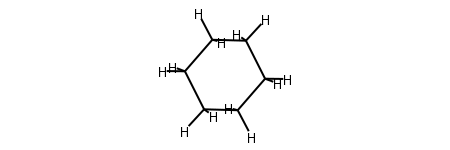

In [11]:
cyclohexane_smiles='C1CCCCC1'

cyclohexane=coords_from_smiles_strings(cyclohexane_smiles)
cyclohexane[0]

In [12]:
your_mesh

In [13]:
ico=2
your_mesh,no_of_rows,no_of_cols=select_mesh(ico)

geneate_unfolded_net(chosen_triangle_index=0, 
                         chosen_direction=0,
                         your_mesh=your_mesh,
                         no_of_rows=16,
                         no_of_cols=5,
                         verbose=True)

###### Generating top row now ######
chosen_triangle_index is 0
chosen_triangle is 
[[ 0.        0.       -1.      ]
 [ 0.425323 -0.309011 -0.850654]
 [-0.162456 -0.499995 -0.850654]]
chosen_point is [ 0.  0. -1.]
top row is [0, 2, 3, 4, 6, 11, 45, 46, 59, 60, 76]
neighbours of chosen triangle are[2, 76]
next triangle in the row is 76
next triangle in the row is located at
[[ 0.425323 -0.309011 -0.850654]
 [ 0.        0.       -1.      ]
 [ 0.425323  0.309011 -0.850654]]


IndexError: list index out of range

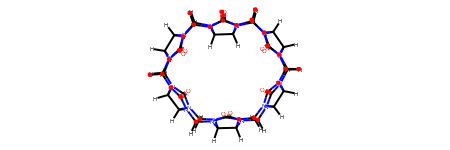

In [16]:
cucurbituril_smiles='C1N2C3C4N(C2=O)CN5C6C7N(C5=O)CN8C9C2N(C8=O)CN5C8C%10N(C5=O)CN5C%11C%12N(C5=O)CN5C%13C(N1C5=O)N1CN3C(=O)N4CN6C(=O)N7CN9C(=O)N2CN8C(=O)N%10CN%11C(=O)N%12CN%13C1=O'

cucurbituril=coords_from_smiles_strings(cucurbituril_smiles)
cucurbituril[0]

In [22]:
molecule=cucurbituril
coords=molecule[1]
atom_list=molecule[2]
colour_list=get_colour_list(atom_list)
len(colour_list)
get_colour_list(atom_list);

NameError: name 'triangles' is not defined

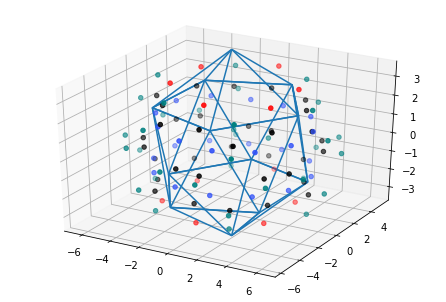

In [23]:
@gif.frame
def plot_icosahedron_and_molecule(i):
    figure = pyplot.figure()
    axes = mplot3d.Axes3D(figure)

    # Load the STL files and add the vectors to the plot
    your_mesh = mesh.Mesh.from_file("C:\\Users\\ella_\\Documents\\GitHub\\icosahedron_projection\\icosahedrons\\icosohedron.stl")
    #axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))
    axes.add_collection3d(mplot3d.art3d.Line3DCollection(your_mesh.vectors*5))
    #axes.add_collection3d(mplot3d.art3d.Patch3DCollection(coords))
    axes.scatter(coords[:,0],coords[:,1],coords[:,2],c=colour_list)
    for atom in range(len(atom_list)):
        normal=your_mesh.normals[triangles[atom]]
        axes.scatter(normal[0]*5,normal[1]*5,normal[2]*5,c=colour_list[atom])
        triangle=your_mesh.vectors[atom]
        axes.scatter(triangle[:,0]*5,triangle[:,1]*5,triangle[:,2]*5,c=colour_list[atom])
        axes.plot([0,coords[atom,0]*2],[0,coords[atom,1]*2],[0,coords[atom,2]*2],c=colour_list[atom])
    # Auto scale to the mesh size
    #scale = your_mesh.points.flatten(-1)
    scale = your_mesh.points.flatten('K')*5
    axes.auto_scale_xyz(scale, scale, scale*0.75)
    axes.view_init(15,i) 
    pyplot.draw()

frames = []
for i in range(360):
    frame = plot_icosahedron_and_molecule(i)
    frames.append(frame)

gif.save(frames, "mehg.gif", duration=50)